# Sentiment Analysis : EDA and model testing

Our project aims at deploying a sentiment prediction API

In this notebook we will first conduct our EDA and then evaluate different approaches

In [3]:
# classic Librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import shutil

# NLTK imports
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# sklearn import 
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn import cluster
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score

# librairies for NLP
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import gensim

# Bert
import transformers
from transformers import TFAutoModel
from transformers import AutoTokenizer

In [4]:
#DATA DOC FROM DATASOURCE (Kaggle)
"""

    target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
    ids: The id of the tweet ( 2087)
    date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
    flag: The query (lyx). If there is no query, then this value is NO_QUERY.
    user: the user that tweeted (robotickilldozr)
    text: the text of the tweet (Lyx is cool)

"""
print()#used to not print documentation. Not pretty but effective

In [5]:
#have to specify header=None because columns names are not implemented correctly
columns_names = ["target","id","date","flag","user","text"]
full_data = pd.read_csv("data/training.1600000.processed.noemoticon.csv", header=None, encoding='latin-1',names=columns_names)
full_data.shape

(1600000, 6)

In [6]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [7]:
full_data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
print("Number of unique items : ", full_data["target"].nunique(), 
      "List of unique items : ",full_data["target"].unique())

Number of unique items :  2 List of unique items :  [0 4]


Need to clean "target" 

In [10]:
full_data.replace({0: "negative", 4: "positive"}, inplace=True)

In [11]:
full_data["target"].value_counts()

target
negative    800000
positive    800000
Name: count, dtype: int64

In [12]:
full_data.describe(include="all")

,target,id,date,flag,user,text
count,1600000,1.600000e+06,1600000,1600000,1600000,1600000
unique,2,NaN,774363,1,659775,1581466
top,negative,NaN,Mon Jun 15 12:53:14 PDT 2009,NO_QUERY,lost_dog,isPlayer Has Died! Sorry
freq,800000,NaN,20,1600000,549,210
mean,NaN,1.998818e+09,NaN,NaN,NaN,NaN
std,NaN,1.935761e+08,NaN,NaN,NaN,NaN
min,NaN,1.467810e+09,NaN,NaN,NaN,NaN
25%,NaN,1.956916e+09,NaN,NaN,NaN,NaN
50%,NaN,2.002102e+09,NaN,NaN,NaN,NaN
75%,NaN,2.177059e+09,NaN,NaN,NaN,NaN


In [13]:
full_data["target"].isna().value_counts()

target
False    1600000
Name: count, dtype: int64

In [14]:
full_data["text"].isna().value_counts()

text
False    1600000
Name: count, dtype: int64

Our 'target' feature is balanced, with no missing values \
Our text has no missing values either \
It seems we can move on without much cleaning

In [16]:
# Take 1% of the data for research and then scale up
data = full_data.sample(frac=0.01, random_state=42, ignore_index=True)  
#data = data.reset_index(drop=True)

In [17]:
#checking 
data["target"].value_counts()

target
positive    8018
negative    7982
Name: count, dtype: int64

In [18]:
data.head()

,target,id,date,flag,user,text
0,negative,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
1,negative,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
2,negative,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
3,negative,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
4,negative,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem


## Text pre_treatment

In [20]:
data.text

0                   @chrishasboobs AHHH I HOPE YOUR OK!!! 
1        @misstoriblack cool , i have no tweet apps  fo...
2        @TiannaChaos i know  just family drama. its la...
3        School email won't open  and I have geography ...
4                                   upper airways problem 
                               ...                        
15995                          On my way to my last exam. 
15996    so, you should go check this guy out, he's pre...
15997    enjoyed a wonderful weekend with my princess &...
15998    got a sore throat  well its not really sore, j...
15999    Just uploading tracks off the new album 'Islan...
Name: text, Length: 16000, dtype: object

In [21]:
# To understand what we are dealing with, let's see the first description
desc = data.text[0]
desc

'@chrishasboobs AHHH I HOPE YOUR OK!!! '

The very first is an interessting case. It is an answer to a tweet including a picture. \
This should be ignored when analyzing tweet \
NOTE TO SELF : prepare a RegEx to ignore or clean out images

In [23]:
# define a RegExp to tokenize only alphanumerics
tokenizer = nltk.RegexpTokenizer(r'\w+')
list_of_words = tokenizer.tokenize(desc)
list_of_words

['chrishasboobs', 'AHHH', 'I', 'HOPE', 'YOUR', 'OK']

This will not exclude images

In [25]:
# lower all characters
lowered_list = [w.lower() for w in list_of_words]
lowered_list
#len(lowered_list)

['chrishasboobs', 'ahhh', 'i', 'hope', 'your', 'ok']

Do we really want to lower_case all characters ? Emphasis can be derived by full caps comments, maybe it should be kept

In [27]:
# stopwords exploration
len(nltk.corpus.stopwords.words('english'))

# stopwords suppression
def stop_word_filter(list_words) :
    stop_w = nltk.corpus.stopwords.words('english')
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

filtered_list = stop_word_filter(lowered_list)
filtered_list
#len(filtered_list)

['chrishasboobs', 'ahhh', 'hope']

We will use lemmatization here \
Tweet are already quite short, and stemming them would be faster but would lose us precious information

In [29]:
def lemmat(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

lemmat_list = lemmat(filtered_list)
lemmat_list
#len(lemmat_list)

['chrishasboobs', 'ahhh', 'hope']

In [30]:
transf_text = ' '.join(lemmat_list)
transf_text

'chrishasboobs ahhh hope'

In [31]:
# Define a treatment function that will be usable on the whole dataset

def cleaning_description_lemmat(text) :
    # Tools used reminder :
    # tokenizer = nltk.RegexpTokenizer(r'\w+')
    # stop_w = nltk.corpus.stopwords.words('english')
    # lemmatizer = WordNetLemmatizer()
    
    list_of_words = tokenizer.tokenize(text)
    lowered_list = [w.lower() for w in list_of_words]
    filtered_list = stop_word_filter(lowered_list)
    lemmat_list = lemmat(filtered_list)
    transformed_text = ' '.join(lemmat_list)

    return transformed_text

In [32]:
text = data["text"][0]
test = cleaning_description_lemmat(text)
test

'chrishasboobs ahhh hope'

In [33]:
#will be used to scale at full dataset
"""from joblib import Parallel, delayed

# Function to process a chunk of data
def process_chunk(chunk):
    chunk['cleaned_text'] = chunk['text'].apply(cleaning_description_lemmat)
    return chunk

# Break your data into smaller chunks and process them in parallel
data_chunks = np.array_split(data, 10)  # Split data into 10 chunks

# Use parallel processing to clean the text
results = Parallel(n_jobs=-1)(delayed(process_chunk)(chunk) for chunk in data_chunks)

# Combine the results back into a single dataframe
cleaned_data = pd.concat(results)
#took 321 seconds"""
print()

In [34]:
data['cleaned_text'] = data['text'].apply(lambda x : cleaning_description_lemmat(x))

In [35]:
data.head()

,target,id,date,flag,user,text,cleaned_text
0,negative,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!,chrishasboobs ahhh hope
1,negative,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo...",misstoriblack cool tweet apps razr
2,negative,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...,tiannachaos know family drama lame hey next ti...
3,negative,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...,school email open geography stuff revise stupi...
4,negative,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem,upper airway problem


## Bag Of Word

In [37]:
# How important is the bag of word ?

#x = data['cleaned_text'].apply(lambda x : len(word_tokenize(x)))
#print("max length bow : ", x)

In [38]:
# create bag of words Tf-idf

ctf = TfidfVectorizer(stop_words='english', max_features=10000)

ctf_transform = ctf.fit_transform(data['cleaned_text'])

In [39]:
ctf_transform

<16000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 89148 stored elements in Compressed Sparse Row format>

In [40]:
"""# PCA to reduce dimensions
pca = PCA(svd_solver='arpack')
pca.fit(ctf_transform)"""
#ill adapted to a large dataset

"# PCA to reduce dimensions\npca = PCA(svd_solver='arpack')\npca.fit(ctf_transform)"

In [41]:
tsne = TSNE(init='random')

TSNE_ctf_transform_2 = tsne.fit_transform(ctf_transform)
TSNE_ctf_transform_2.shape

(16000, 2)

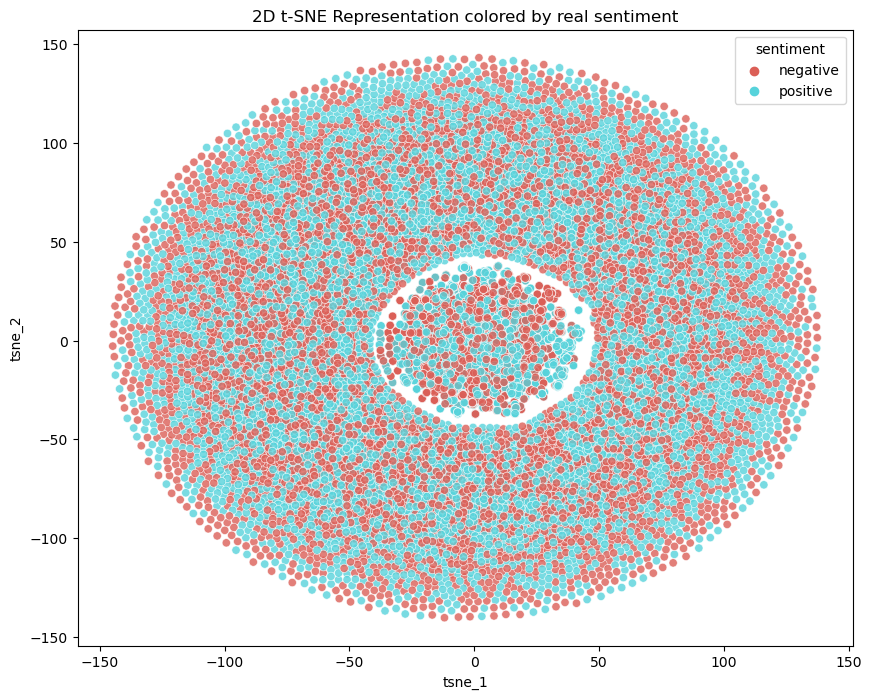

In [42]:
sentiment = data['target']

df_real_sentiment = pd.DataFrame({
    'tsne_1': TSNE_ctf_transform_2[:, 0],
    'tsne_2': TSNE_ctf_transform_2[:, 1],
    'sentiment': sentiment
})

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='tsne_1', y='tsne_2', 
    hue='sentiment',
    palette=sns.color_palette('hls', len(df_real_sentiment['sentiment'].unique())),
    data=df_real_sentiment,
    legend='full',
    alpha=0.8
)
plt.title('2D t-SNE Representation colored by real sentiment')
plt.show()

In [43]:
from sklearn.model_selection import train_test_split

X = data['cleaned_text']
y = data['target']

# Initial split to create a test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Second split to create validation set from the train+validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000)  # Limit the number of features to avoid overfitting
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

cross validation avec gridsearch pour opti les HP avec cv=5
faire pipeline

### Logisitc Regression Baseline with tf-idf

In [47]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score


def train_model(model, params, scores, X, y):
    '''
    Train model with CV and grid search.
            Parameters:
                    model: model's initialization
                    params : model's hyperparametres
                    X, y : Data to train
            Returns:
                    grid search results
    '''
    pipeline = Pipeline(steps=[
        ['classifier', model]
    ])
    grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=params,
                           scoring=scores,
                           refit='accuracy',
                           n_jobs=-1)

    return grid_search.fit(X,y)

In [48]:
clf = LogisticRegressionCV(random_state=42, max_iter=1000)
params = {'classifier__cv' : [5, 10], 
                'classifier__Cs' : [1, 10, 100],
               'classifier__penalty':['l2']}
scores = {'roc_auc': 'roc_auc', 
          'accuracy': 'accuracy',
          'precision':'precision',
          'recall':'recall'}

In [49]:
tfidf_model = train_model(clf, params, scores, X_train_tfidf, y_train)
tfidf_model

C:\Users\kanam\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[['classifier',
                                        LogisticRegressionCV(max_iter=1000,
                                                             random_state=42)]]),
             n_jobs=-1,
             param_grid={'classifier__Cs': [1, 10, 100],
                         'classifier__cv': [5, 10],
                         'classifier__penalty': ['l2']},
             refit='accuracy',
             scoring={'accuracy': 'accuracy', 'precision': 'precision',
                      'recall': 'recall', 'roc_auc': 'roc_auc'})

In [50]:
# Predict on the test set
y_pred = tfidf_model.predict(X_test_tfidf)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.7415625
              precision    recall  f1-score   support

    negative       0.75      0.73      0.74      1596
    positive       0.74      0.76      0.75      1604

    accuracy                           0.74      3200
   macro avg       0.74      0.74      0.74      3200
weighted avg       0.74      0.74      0.74      3200



In [51]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}")

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, tfidf_model.predict_proba(X_test_tfidf)[:, 1])
print(f"ROC-AUC: {roc_auc}")

Confusion Matrix:
[[1158  438]
 [ 389 1215]]
ROC-AUC: 0.8161269757935987


In [52]:
testing_sentence = ["baguette"]
testing_sentence_tfidf = vectorizer.transform(testing_sentence)

print(tfidf_model.predict_proba(testing_sentence_tfidf),tfidf_model.predict(testing_sentence_tfidf))

[[0.47674823 0.52325177]] ['positive']


Some words that are not seen in training (such as other languages) still returns a 'positive' result

This could be explained by a slight bias towards positive class

## FastText approach

In [55]:
type(X_train)

pandas.core.series.Series

In [56]:
import gensim
from gensim.models import FastText

# Step 1: Tokenize your sentences
#sentences = [gensim.utils.simple_preprocess(text) for text in X_train_fasttext]  # Tokenize X_train text data
sentences = X_train
# Step 2: Train FastText model
fasttext_model = FastText(sentences=X_train, vector_size=100, window=5, min_count=1, workers=4, sg=1)

# Explanation:
# - vector_size: Dimensionality of word vectors
# - window: Context window size
# - min_count: Ignores words with total frequency lower than this
# - workers: Number of threads for training
# - sg: 1 for skip-gram (better for smaller datasets), 0 for CBOW

# Train the FastText model
fasttext_model.train(sentences, total_examples=len(sentences), epochs=10)


(829732, 4500550)

In [57]:
def get_sentence_embedding(sentence, model):
    """
    Generate a sentence embedding by averaging FastText word embeddings.
    Parameters:
        sentence: List of words (tokenized sentence).
        model: Trained FastText model.
    Returns:
        A vector representing the sentence.
    """
    valid_words = [word for word in sentence if word in model.wv]
    if valid_words:
        return np.mean([model.wv[word] for word in valid_words], axis=0)
    else:
        return np.zeros(model.vector_size)

# Create embeddings for train and validation sets
X_train_fasttext = np.array([get_sentence_embedding(sentence, fasttext_model) for sentence in sentences])

# For the validation set
sentences_val = [gensim.utils.simple_preprocess(text) for text in X_val]
X_val_fasttext = np.array([get_sentence_embedding(sentence, fasttext_model) for sentence in sentences_val])


In [58]:
len(X_train_fasttext)

9600

In [59]:
# Initialize and train the classifier
fast_classifier = train_model(clf, params, scores, X_train_fasttext, y_train)
fast_classifier

C:\Users\kanam\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[['classifier',
                                        LogisticRegressionCV(max_iter=1000,
                                                             random_state=42)]]),
             n_jobs=-1,
             param_grid={'classifier__Cs': [1, 10, 100],
                         'classifier__cv': [5, 10],
                         'classifier__penalty': ['l2']},
             refit='accuracy',
             scoring={'accuracy': 'accuracy', 'precision': 'precision',
                      'recall': 'recall', 'roc_auc': 'roc_auc'})

In [60]:
# Evaluate on the validation set
y_val_pred = fast_classifier.predict(X_val_fasttext)

# Display validation metrics
print("Validation Set Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))


Validation Set Accuracy: 0.5009375
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00      1597
    positive       0.50      1.00      0.67      1603

    accuracy                           0.50      3200
   macro avg       0.25      0.50      0.33      3200
weighted avg       0.25      0.50      0.33      3200



C:\Users\kanam\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kanam\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kanam\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [61]:
# Function to predict sentiment for a new text input
def predict_sentiment(text, model, classifier):
    
    # Generate sentence embedding using FastText model
    embedding = get_sentence_embedding(text, model)
    
    # Reshape for prediction (1 sample with vector size)
    embedding = embedding.reshape(1, -1)
    
    # Predict sentiment
    prediction = fast_classifier.predict(embedding)
    proba = fast_classifier.predict_proba(embedding)

    return prediction, proba

# Test the function with a random text
random_text = "I had a wonderful experience with Air Paradis!"
pred, prob = predict_sentiment(random_text, fasttext_model, fast_classifier)
print(f"Predicted Sentiment is {pred} with probability of {prob}")


Predicted Sentiment is ['negative'] with probability of [[0.57677428 0.42322572]]


The results are very poor, model won't be kept

### BERT testing zone

In [64]:
from transformers import BertTokenizer

# BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Using my text cleaning function with BERT tokenizer
def preprocess_text_for_bert(texts, max_len=128):
    """
    Clean text using custom preprocessing and tokenize it for BERT.
    
    Parameters:
        texts: List of strings (raw text input).
        max_len: Maximum sequence length for BERT input.
    
    Returns:
        A dictionary with 'input_ids' and 'attention_mask'.
    """
    # Applying my function to all texts
    cleaned_texts = [cleaning_description_lemmat(text) for text in texts]

    # BERT tokenizer
    encodings = tokenizer(
        cleaned_texts,
        truncation=True,
        padding=True,
        max_length=max_len,
        return_tensors="tf"
    )
    
    return encodings

In [65]:
test = "hello"
# Preprocess text input to BERT-compatible format
bert_inputs = preprocess_text_for_bert(test)

print(bert_inputs)

{'input_ids': <tf.Tensor: shape=(5, 2), dtype=int32, numpy=
array([[101, 102],
       [101, 102],
       [101, 102],
       [101, 102],
       [101, 102]])>, 'token_type_ids': <tf.Tensor: shape=(5, 2), dtype=int32, numpy=
array([[0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0]])>, 'attention_mask': <tf.Tensor: shape=(5, 2), dtype=int32, numpy=
array([[1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1]])>}


In [66]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Lambda
from tensorflow.keras.models import Model

# Define the BERT + LSTM model
def create_model(bert_model_url, max_len=128, lstm_units=64, dropout_rate=0.3):
    # Input layer for raw text
    text_input = Input(shape=(), dtype=tf.string, name="text_input")
    
    # Use the BERT tokenizer from the hub module to preprocess text
    preprocessor = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", 
        name="preprocessing"
    )

    # Preprocess text input to BERT-compatible format
    bert_inputs = preprocessor(text_input)

    # Load the BERT model
    bert_encoder = hub.KerasLayer(bert_model_url, trainable=True, name="BERT_Encoder")

    # Extract BERT outputs
    bert_outputs = bert_encoder(bert_inputs)
    cls_output = bert_outputs['pooled_output']         # Sentence-level embedding
    sequence_output = bert_outputs['sequence_output']  # Token-level embeddings

    # Pass the token-level embeddings through an LSTM layer
    x = LSTM(lstm_units)(sequence_output)
    x = Dropout(dropout_rate)(x)
    x = Dense(32, activation="relu")(x)
    x = Dropout(dropout_rate)(x)

    # Output layer for binary classification
    output = Dense(1, activation="sigmoid")(x)

    # Create and compile the model
    model = Model(inputs=text_input, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

# Define the model
model_url = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/3"
model = create_model(model_url)


RuntimeError: Op type not registered 'CaseFoldUTF8' in binary running on APOXYS. Make sure the Op and Kernel are registered in the binary running in this process. Note that if you are loading a saved graph which used ops from tf.contrib (e.g. `tf.contrib.resampler`), accessing should be done before importing the graph, as contrib ops are lazily registered when the module is first accessed.

In [ ]:
def predict_sentiment(text, tokenizer, model, max_len=128):
    # Tokenize the input text
    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_len,
        return_tensors="tf"
    )
    
    # Predict the sentiment
    input_ids = encoding["input_ids"]
    attention_mask = encoding["attention_mask"]
    prediction = model.predict({"input_ids": input_ids, "attention_mask": attention_mask})
    
    # Convert the prediction to a label
    sentiment = "Positive" if prediction[0] > 0.5 else "Negative"
    return sentiment

# Test with a random example
random_text = "I had a wonderful experience !"
print("Predicted Sentiment:", predict_sentiment(random_text, tokenizer, model))


## BERT

In [ ]:
# Sentences prep function
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Feature creation function (with huggingface and TF as options)
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids,
                                 "input_mask" : attention_mask,
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1, 2)
    print(f"It took : {time2} seconds")
     
    return features_bert, last_hidden_states_tot

In [ ]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = data['cleaned_text'].to_list()

In [ ]:
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

In [ ]:
BERT_embeddings = tsne.fit_transform(features_bert)
BERT_embeddings.shape

In [ ]:
kmeans.fit(BERT_embeddings)
data['clustering_BERT'] = kmeans.predict(BERT_embeddings)

In [ ]:
# prepare BERT visualisation
df_clustering_BERT = pd.DataFrame({
    'tsne_1': BERT_embeddings[:, 0],
    'tsne_2': BERT_embeddings[:, 1],
    'clusters': data['clustering_BERT']
})

# Compare Tf-idf clustering against true categories
fig, ax = plt.subplots(1, 2, figsize=(25, 8))

sns.scatterplot(
    ax=ax[0],
     x='tsne_1', y='tsne_2', 
    hue='sentiment',
    palette=sns.color_palette('hls', len(df_real_sentiment['sentiment'].unique())),
    data=df_real_sentiment,
    legend='full',
    alpha=0.8
)

ax[0].set_title('2D t-SNE Representation colored by real sentiment')

sns.scatterplot(
    ax=ax[1],
    x='tsne_1', y='tsne_2',
    hue='clusters',
    palette=sns.color_palette('hls', len(df_clustering_BERT['clusters'].unique())),
    data=df_clustering_BERT,
    legend='full',
    alpha=0.8
)
ax[1].set_title('2D t-SNE Representation colored by BERT Clustering')


plt.show()

In [ ]:
ari_clustering = adjusted_rand_score(data['target'], data['clustering_BERT'])
print('Similarity score :', ari_clustering)

models not going above 3% accuracy